<a href="https://colab.research.google.com/github/zychen1017/R--/blob/main/Repeat_Buyers_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
train_df = pd.read_csv('dataset.csv')
user_info = pd.read_csv('user_info_format1.csv')
user_log = pd.read_csv('user_log_format1.csv').rename(columns={'seller_id':'merchant_id'})
user_log1 = pd.read_csv('user_log_format1.csv')

In [ ]:
user_log.head(1)  # the name of columns is different. we should change it to match train_df

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0.0


In [ ]:
user_log1.head(1)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0.0


In [ ]:
train_df.head(1)

,user_id,merchant_id,label
0,34176,3906,0


In [ ]:
#填充缺失值
user_info['gender'].fillna(2, inplace=True) #2和null都代表性别不确定
user_info['age_range'].fillna(-1, inplace=True)
user_log['brand_id'].fillna(-1, inplace=True)

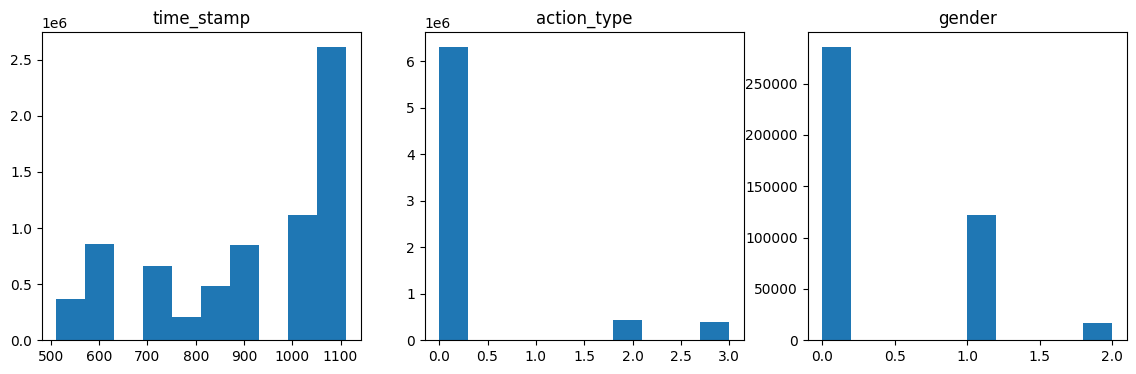

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.hist(user_log['time_stamp']) #time_tamp 购买时间（格式：mmdd）
plt.title('time_stamp')
plt.subplot(1,3,2)
plt.hist(user_log['action_type'])
plt.title('action_type') #action_type包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
plt.subplot(1,3,3)
plt.hist(user_info['gender']) #gender用户性别。0表示女性，1表示男性，2和NULL表示未知
plt.title('gender')
plt.show()

Non-repeat buyers VS. Repeat buyers：
 label
0    244912
1     15952
Name: user_id, dtype: int64


<Axes: ylabel='label'>

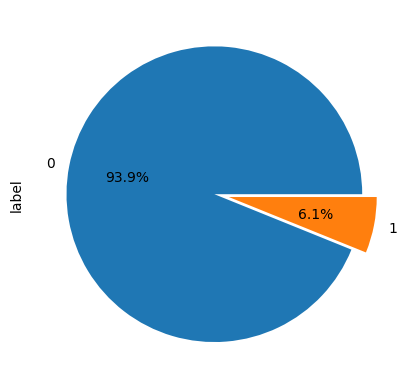

In [ ]:
label_gp = train_df.groupby('label')['user_id'].count()
print('Non-repeat buyers VS. Repeat buyers：\n',label_gp)
train_df.label.value_counts().plot(kind='pie',autopct='%1.1f%%',explode=[0,0.1])

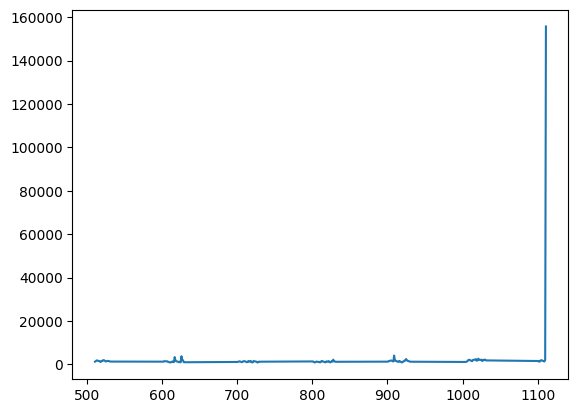

In [ ]:
from matplotlib import pyplot as plt
plt.plot(user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'])
plt.show()

In [ ]:
seller_group = user_log.groupby(["merchant_id","action_type"]).count()[["user_id"]].reset_index().rename(columns={'user_id':'count'})

In [ ]:
seller_group.sample(5)

,merchant_id,action_type,count
2919,830,3.0,512
2586,738,2.0,207
9471,2685,3.0,14
12191,3460,3.0,184
1549,443,2.0,34


In [ ]:
seller_feature = seller_group[seller_group['action_type']==0][['merchant_id','count']].reset_index()[['merchant_id','count']].rename(
    columns={'count':'click_count'})

def _get_action_cnt(num):
    seller_df = seller_group[seller_group['action_type']==num]
    cnt_list = []
    for i in seller_feature['merchant_id']:
        l = list(seller_df['count'][seller_df['merchant_id']==i])
        if l:
            cnt_list.append(l[0])
        else:
            cnt_list.append(0)
    return cnt_list
            
seller_feature['cart_count'] = _get_action_cnt(1)
seller_feature['sell_count'] = _get_action_cnt(2)
seller_feature['star_count'] = _get_action_cnt(3)
seller_feature.head()

,merchant_id,click_count,cart_count,sell_count,star_count
0,1,41202,49,2346,1725
1,2,276,4,23,21
2,3,300,0,7,25
3,4,369,0,46,30
4,5,981,0,25,73


In [ ]:
train_df.head(1)

,user_id,merchant_id,label
0,34176,3906,0


In [ ]:

train_df = train_df.merge(seller_feature,on="merchant_id",how='left')
train_df

,user_id,merchant_id,label,click_count,cart_count,sell_count,star_count
0,34176,3906,0,2125,3,70,140
1,34176,121,0,9820,28,712,338
2,34176,4356,1,726,1,108,20
3,34176,2217,0,6640,10,466,534
4,230784,4818,0,5659,26,343,257
...,...,...,...,...,...,...,...
260859,359807,4325,0,2228,3,289,143
260860,294527,3971,0,3045,12,293,179
260861,294527,152,0,822,1,92,58
260862,294527,2537,0,4938,11,811,280


In [ ]:

for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']<1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}'.format(i)})

In [ ]:
for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']==1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}_in1111'.format(i)})

In [ ]:
train_df = train_df.fillna(0)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 0 to 260863
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              260864 non-null  int64  
 1   merchant_id          260864 non-null  int64  
 2   label                260864 non-null  int64  
 3   click_count          260864 non-null  int64  
 4   cart_count           260864 non-null  int64  
 5   sell_count           260864 non-null  int64  
 6   star_count           260864 non-null  int64  
 7   action_type0         260864 non-null  float64
 8   action_type1         260864 non-null  float64
 9   action_type3         260864 non-null  float64
 10  action_type0_in1111  260864 non-null  float64
 11  action_type1_in1111  260864 non-null  float64
 12  action_type3_in1111  260864 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 27.9 MB


In [ ]:
for i in (0,1,3):
    train_df['action{}_rate'.format(i)] = train_df.apply(lambda x:x['action_type{}_in1111'.format(i)]/x['action_type{}'.format(i)] if x['action_type{}'.format(i)]>0 else -1, axis=1)

In [ ]:
train_df['action0_rate'].value_counts()

-1.000000    247203
 0.000000      2560
 1.000000      1133
 0.500000       703
 2.000000       601
              ...  
 3.928571         1
 0.517241         1
 2.593750         1
 4.428571         1
 0.566667         1
Name: action0_rate, Length: 970, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import lightgbm as lgb

x = train_df.drop(['user_id','merchant_id','label'],axis=1)
y = train_df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 42)

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(y_test, y_score):
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()

模型的评估报告：
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     49026
           1       0.40      0.00      0.00      3147

    accuracy                           0.94     52173
   macro avg       0.67      0.50      0.49     52173
weighted avg       0.91      0.94      0.91     52173



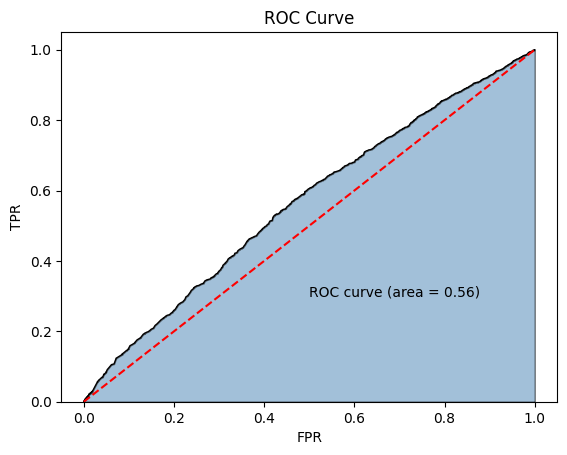

In [ ]:
#数据不平衡，recall很差
lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_proba = lr.predict_proba(x_test)
print('模型的评估报告：\n',classification_report(y_test, lr_pred))
plot_roc(y_test, lr_proba[:,1])

模型的评估报告：
               precision    recall  f1-score   support

           0       0.95      0.67      0.79     49026
           1       0.08      0.42      0.13      3147

    accuracy                           0.66     52173
   macro avg       0.51      0.55      0.46     52173
weighted avg       0.90      0.66      0.75     52173



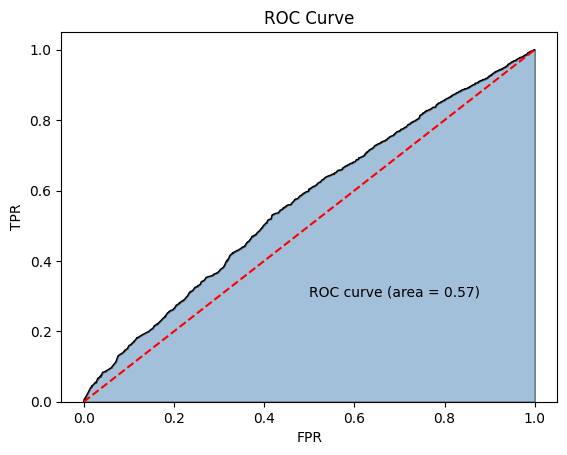

In [ ]:
#balance一下
lr = LogisticRegression(solver='liblinear',class_weight='balanced')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_proba = lr.predict_proba(x_test)
print('模型的评估报告：\n',classification_report(y_test, lr_pred))
plot_roc(y_test, lr_proba[:,1])

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report：
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     49026
           1       0.00      0.00      0.00      3147

    accuracy                           0.94     52173
   macro avg       0.47      0.50      0.48     52173
weighted avg       0.88      0.94      0.91     52173



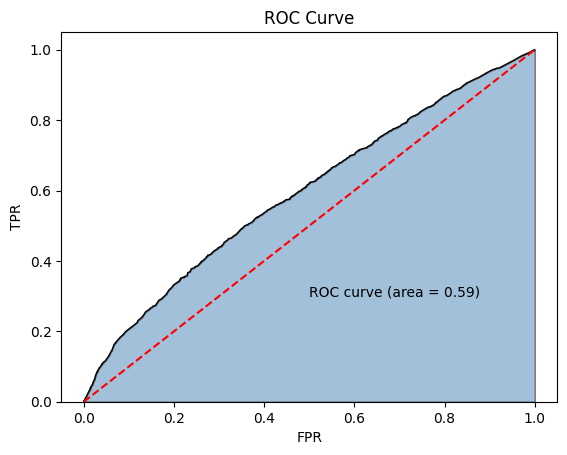

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50,random_state=44,max_depth=5)
rfc = rfc.fit(x_train, y_train)


rfc_pred = rfc.predict(x_test)

rfc_proba = rfc.predict_proba(x_test)
print('Report：\n',classification_report(y_test, rfc_pred))
plot_roc(y_test, rfc_proba[:,1])

In [ ]:
params = {
        'verbose':0,
        'min_data_in_leaf': 4,
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 32,
        'n_estimators':2000,
        #'max_bin': 50,
        'max_depth':5,
        "learning_rate": 0.01,
        "colsample_bytree": 0.8,  # 每次迭代中随机选择特征的比例
        "bagging_fraction": 0.8,  # 每次迭代时用的数据比例
        'n_jobs': -1,
        'silent': 1,  # 信息输出设置成1则没有信息输出
        'seed': 42,
        'bagging_freq':3,
        'is_unbalance':True,
        #'scale_pos_weight': wt
    }  #设置出参数

gbm = lgb.LGBMClassifier(**params)
gbm.fit(x_train, y_train, 
            eval_metric='auc',
    eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=30)
gbm_pred = gbm.predict(x_test)
gbm_proba = gbm.predict_proba(x_test)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. 

Report：
               precision    recall  f1-score   support

           0       0.96      0.68      0.79     49026
           1       0.09      0.52      0.16      3147

    accuracy                           0.67     52173
   macro avg       0.53      0.60      0.48     52173
weighted avg       0.90      0.67      0.75     52173



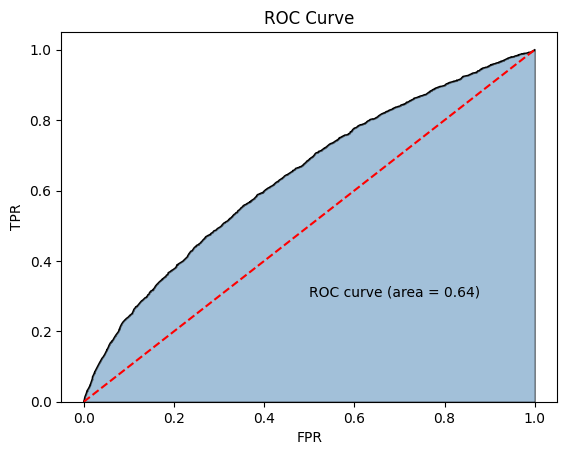

In [ ]:
print('Report：\n',classification_report(y_test, gbm_pred))
plot_roc(y_test, gbm_proba[:,1])

In [ ]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(
        max_depth=10,
        n_estimators=100,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=100       
    )
model_xgb.fit(
        x_train, 
        y_train,
        eval_metric='auc',
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=10
    )
print(model_xgb.best_score)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.59624	validation_1-auc:0.59684
[1]	validation_0-auc:0.60446	validation_1-auc:0.60750
[2]	validation_0-auc:0.61414	validation_1-auc:0.60876
[3]	validation_0-auc:0.61809	validation_1-auc:0.61382
[4]	validation_0-auc:0.62283	validation_1-auc:0.61992
[5]	validation_0-auc:0.62864	validation_1-auc:0.62084
[6]	validation_0-auc:0.62979	validation_1-auc:0.62248
[7]	validation_0-auc:0.63017	validation_1-auc:0.62336
[8]	validation_0-auc:0.63050	validation_1-auc:0.62273
[9]	validation_0-auc:0.63055	validation_1-auc:0.62262
[10]	validation_0-auc:0.63116	validation_1-auc:0.62205
[11]	validation_0-auc:0.63188	validation_1-auc:0.62379
[12]	validation_0-auc:0.63247	validation_1-auc:0.62399
[13]	validation_0-auc:0.63287	validation_1-auc:0.62380
[14]	validation_0-auc:0.63350	validation_1-auc:0.62339
[15]	validation_0-auc:0.63483	validation_1-auc:0.62450
[16]	validation_0-auc:0.63526	validation_1-auc:0.62432
[17]	validation_0-auc:0.63657	validation_1-auc:0.62485
[18]	validation_0-au

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report：
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     49026
           1       0.00      0.00      0.00      3147

    accuracy                           0.94     52173
   macro avg       0.47      0.50      0.48     52173
weighted avg       0.88      0.94      0.91     52173



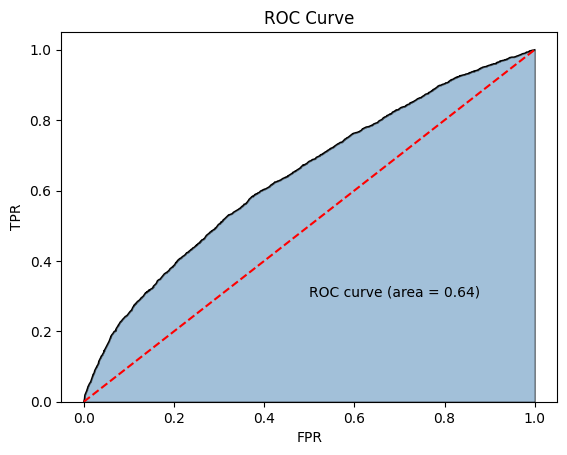

In [ ]:
# make a prediction
model_xgb_pred = model_xgb.predict(x_test)

model_xgb_proba = model_xgb.predict_proba(x_test)
print('Report：\n',classification_report(y_test, model_xgb_pred))
plot_roc(y_test, model_xgb_proba[:,1])